In [1]:
%load_ext autoreload
%autoreload 2

# --------------------------------------------------------------------------------

import os
import sys
from pathlib import Path
import numpy as np
np.warnings.filterwarnings('ignore')

# hex2cec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{os.environ['HOME']}/hex2vec")
sys.path.insert(0, f"{os.environ['HOME']}/amazon-routing-challenge")
sys.path.insert(0, '/home/ext_navish_iitkgp_gmail_com/cqr')

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
import urban_tools.hex_pipeline as hp
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import h3
import gcsfs

%matplotlib inline
import matplotlib.pyplot as plt
## Read in the DataFrame

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/12.12.22-Revised-Embeddings/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
hh.print_history()
hh = hh.drop_zero_tags()
### Drop Tags that occur in <X% of a City
# percentage = 0.01
# import pandas as pd

# drop_cols = pd.Index([])
# for _hh in [hh]:
#     assert _hh.df["city"].unique().shape[0] == 1
#     h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
#     percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
#     drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
# hh.drop_cols(drop_cols)
# len(hh.all_tags)
### Append the embedding to the dataframe
# embedding_df = pd.read_parquet(
#     hh.my_folder / "embeddings.prq"
# )
embedding_df = pd.read_feather(
    "/gcsmount-research-data-staging/hex2vec-models/paper-final/embedding_dfs/subtags+cities+littlemodel.feather"
)
embedding_df = embedding_df.set_index("h3")
# embedding_df.columns = [f"e_{e}" for e in embedding_df.columns]
# embedding_df = embedding_df[embedding_df.columns.str.]
# embedding_columns = embedding_df.columns.copy()
# embedding_df = embedding_df.reset_index()

hh.df = hh.df.merge(embedding_df, on="h3", how="left")
hh.update_tags()
hh.df = hh.df.dropna(subset=hh.embeddings)
### Filter for only H3 with > X Data Points

# tagged_df = tagged_df.loc[tagged_df["h3_9"] > 20].copy()
hh = hh.filter_hex_occurance(20)
hh.df = hh.df[hh.df.city.str.contains('Boston')]
# hh.df.drop("h3_9", axis=1, inplace=True)
# print(tagged_df.shape)
hh.df = hh.df.reset_index(drop=True)

read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
Merge building_residential + building_house -> building_yes(*(), **{})
drop_zero_buildings(*(), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'grouped': False, 'tukey_fences': False})
open_route_df(*(), **{'grouped': False, 'tukey_fences': False})
drop_zero_tags(*(), **{})


### Create the TT Manager

In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from scipy.stats import pearsonr

In [3]:
tt = TestTrainManager(
    hh.df,
    x_col=hh.embeddings.union(hh.special_tags).union(hh.super_tags),
    y_col=["planned_service_time_log"],
    scaler=RobustScaler,
    grouped=False,
    desired_quantiles=[0.5, 0.90]
)

tt.split_test_train(train_size=0.8, random_seed=42)
tt.scale_test_train()
tt.build_test_df(agg=False)

In [4]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.planned_service_time_log.values.ravel(), tt.X_test.values, tt.Y_test.loc.values
n_train = X_train.shape[0]
# X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

In [5]:
X_train.shape, X_test.shape

((14135, 74), (3347, 74))

## PCA

In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

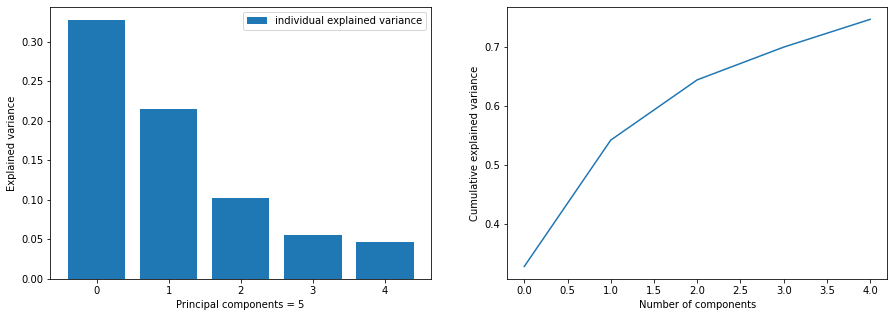

In [7]:
# n_components = X_train.shape[1]
n_components = 5
pca = PCA(n_components=n_components)
# pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)
X_pca = pca.fit_transform(X_train)
explained_variance=pca.explained_variance_ratio_

# explained_variance = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))

# create subplots for cumulative explained variance and individual explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot individual explained variance
ax1.bar(range(n_components), explained_variance, label='individual explained variance')
ax1.set_xlabel(f'Principal components = {n_components}')
ax1.set_ylabel('Explained variance')
ax1.legend()

# plot cumulative explained variance
ax2.plot(np.cumsum(explained_variance))
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative explained variance')

plt.show()


In [8]:
import torch
import random
from sklearn.model_selection import train_test_split

seed = 1

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.05, 0.95]

# using PCA components instead of raw data
X_train = X_pca
X_test = pca.transform(X_test)

# compute input dimensions
n_train = X_train.shape[0]
in_shape = X_train.shape[1]

# display basic information
print("Dataset: %s" % ('Boston Delivery Level'))
print("Dimensions: train set (n=%d, d=%d) ; test set (n=%d, d=%d)" % 
      (X_train.shape[0], X_train.shape[1], X_test.shape[0], X_test.shape[1]))

Dataset: Boston Delivery Level
Dimensions: train set (n=14135, d=5) ; test set (n=3347, d=5)


### CQR random forests

In [9]:
#########################################################
# Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py): https://github.com/yromano/cqr/blob/master/cqr/helper.py
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = X_train.shape[1]

# target quantile levels
quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10

In [10]:
# !pip install -U scikit-learn==0.21.3

In [11]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc


# define the QRF's parameters 
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, X_train, y_train, X_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Random Forests")

/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depr

CQR Random Forests: Percentage in the range (expecting 90.00): 91.723932
CQR Random Forests: Average length: 2.268667



### Asymmetric nonconformity score 

In [11]:
from nonconformist.nc import QuantileRegAsymmetricErrFunc
import numpy as np
np.warnings.filterwarnings('ignore')

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegAsymmetricErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, X_train, y_train, X_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "Asymmetric CQR Random Forests")

NameError: name 'helper' is not defined

## CQR neural net

In [ ]:
#####################################################
# Neural network parameters
# (See AllQNet_RegressorAdapter class in helper.py)
#####################################################

# pytorch's optimizer object
nn_learn_func = torch.optim.Adam

# number of epochs
epochs = 1000

# learning rate
lr = 0.0005

# mini-batch size
batch_size = 64

# hidden dimension of the network
hidden_size = 64

# dropout regularization rate
dropout = 0.1

# weight decay regularization
wd = 1e-6

# Ask for a reduced coverage when tuning the network parameters by 
# cross-validataion to avoid too concervative initial estimation of the 
# prediction interval. This estimation will be conformalized by CQR.
quantiles_net = [0.1, 0.9]

In [ ]:
# define quantile neural network model
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=False)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, X_train.astype(np.float32), y_train.astype(np.float32), X_test.astype(np.float32), idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Neural Net")

CQR Neural Net: Percentage in the range (expecting 90.00): 100.000000
CQR Neural Net: Average length: 2.101049


## CQR neural net with rearrangement

In [ ]:
# define quantile neural network model, using the rearrangement algorithm
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=True)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, X_train.astype(np.float32), y_train.astype(np.float32), X_test.astype(np.float32), idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_re_qnet, length_cp_re_qnet = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Rearrangement Neural Net")

CQR Rearrangement Neural Net: Percentage in the range (expecting 90.00): 100.000000
CQR Rearrangement Neural Net: Average length: 2.093840
